# Symbolic computation using BDDs in AEON.py

This notebook shows examples of how to use binary decision diagrams (BDDs) available in the AEON.py tool. It assumes that you already know what BDDs are and their capabilities (i.e., we will not talk about BDDs, just the technical implementation of the library).

Compared to other BDD libraries, here we do not have a single shared "BDD storage" or "BDD manager". Instead, **every BDD is a separate object**, which means it can be more easily passed around during asynchronous or parallel computing (i.e. more than one BDD operation can be running at the same time).

That being said, we still use a separate `BddVariableSet` to manage the mapping from *names* to the BDD variables, since these are not used as often and there is no need to keep them around in each BDD. This `BddVariableSet` object is also used to initially create atomic BDDs, so it is probably the first thing that you'll need to create before creating the BDDs. However, each BDD actually maintains the *number* of variables that it supports (which is injected based on the `BddVariableSet`), and you **cannot mix BDDs with a different variable count**. So in practice, you should try to only use together BDDs created using the same `BddVariableSet` (You can migrate BDDs between variable sets using `BddVariableSet.transfer_from` as long as the relevant variables appear in both sets). 

In [1]:
from biodivine_aeon import *

To create a `BddVariableSet`, you have two options: If you already know the number of variables (and their names), you can create it directly. Alternatively, you can create it gradually using a `BddVariableSetBuilder` while figuring out what variables to use.

In [2]:
# Create a BddVariableSet with 5 variables names a, b, c, d, e.
vars = BddVariableSet(["a", "b", "c", "d", "e"])
assert vars.variable_count() == 5
# To actually use the variables in the future, we have to use a reference. 
# Here, v_a now contains a BDD variable reference. 
v_a = vars.find_variable("a")
v_c = vars.find_variable("c")

# For example, we can use the variable reference to create a literal.
# That is, a BDD which corresponds either to just "a", or to "!a".
positive_bdd_literal = vars.mk_literal(v_a, True)
negative_bdd_literal = vars.mk_literal(v_a, False)

# We can also use the variable set to create constants:
bdd_true = vars.mk_const(True)

assert positive_bdd_literal.is_true() == False
assert bdd_true.is_true() == True  

# You can create an "anonymous" variable set, where the names of 
# the variables are "x_0", "x_1", ... , "x_{n-1}" by default
anonymous_vars = BddVariableSet(10)

# It is always possible to obtain all variables in the set, just in case:
actual_anonymous_vars = anonymous_vars.variable_ids()

# This gives you a list of all "variable references". 
# You can however read back their names easily:
print([ anonymous_vars.get_variable_name(v) for v in actual_anonymous_vars ])
# Since this is a common operation, we also have a utility function for that:
print(anonymous_vars.variable_names())

['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9']
['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9']


In some cases, you don't know the number (or names) of variables initially. For example, you want to have a function that creates the variables while reading the problem input, and saves the BDD variable references for future use:

In [3]:
builder = BddVariableSetBuilder()

# You can create variables one by one, and the builder will always 
# give you the variable reference for later use.
v_first = builder.add("first")

# You can also create multiple variable at the same time if you want to.
created = builder.add_all(["second", "third", "fourth"])
v_third = created[1]

# In the end, you can just call build to turn the builder into 
# a valid variable set.
four_vars = builder.build()
four_vars.variable_count()

4

Note that the library will automatically check whether you used duplicate variables. Furthermore, some special characters (like `!` or other logical operators) cannot be used in a variable name.

The reason for this is mainly that `BddVariableSet` can actually do quite a bit more than what we've shown already:

In [4]:
# If you have a formula that you want to quickly turn into a BDD, you can simply evaluate it as a string:
# (as long as the variable names match the ones in your BddVariableSet)
formula = vars.eval_expression("a & (b => !c) & (d <=> (c & !a))")

# Furthermore, if you have a formula saved in CNF/DNF, you can also build it quite easily.
# Each element in the list is a dictionary containing the literals in the CNF/DNF clause. 
# These can use either the BDD variable references, or the names of the variables
conjunction = vars.mk_cnf([{v_a: True, "b": False}, {"c": False, "d": False}, {v_a: True, "c": True}])

# If you only want to create one clause, you can do that as well:
clause = vars.mk_conjunctive_clause({v_a: True, "b": False, "c": True})
clause.cardinality() # Get the number of valuations satisfied in this BDD.

4

To visually inspect the BDDs, you can use a conversion to `.dot`. Here, we are using `graphviz` to actually show the pictures of the BDD:

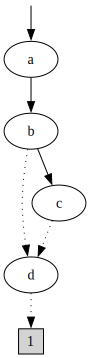

In [5]:
import graphviz

graphviz.Source(formula.to_dot())

For readability, the generated plot omits edges that lead to the `zero` terminal node. We can show these edges with an optional argument:

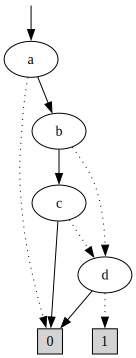

In [6]:
graphviz.Source(formula.to_dot(zero_pruned=False))

We can also convert the BDD back to a Boolean expression. However, we are not doing any special minification of the formula here, so the result will be probably larger than the original formula:

In [7]:
formula.to_expression()

BooleanExpression("(a & ((b & (!c & !d)) | (!b & !d)))")

To actually manipulate the BDDs, we can use normal logical operators, as well as projection and selection. But note that Python automatically translates methods `and` and `or` to reserved operators, even if used as method names. Therefore, we opted to use a prefix `l_*` to denote the logical operations and `r_*` to denote relational operations:

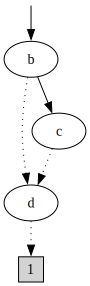

In [8]:
# Basic logical operators:

formula.l_and(conjunction)
formula.l_or(conjunction)
formula.l_xor(conjunction)
formula.l_imp(conjunction)
formula.l_iff(conjunction)
formula.l_and_not(conjunction)

# Projection, either using one variable, or a set of variables.
# Here, we have to use variable references instead of names though, 
# since the BDD object has no idea what the actual names of the variables are.
formula.r_exists([v_a, v_c])
formula.r_for_all([v_a, v_c])

# Projection "removes" the influence of a particular variable: F = F[a/0] | F[a/1]
graphviz.Source(formula.r_exists(v_a).to_dot())

Similarly, we can use selection to actually fix a variable to a specific value. Here, we have to also include the Boolean value to which we are fixing. The argument is therefore a dictionary whose keys are BDD variable references.

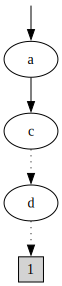

In [9]:
graphviz.Source(formula.r_select({ v_c: False }).to_dot())

Finally, to transfer and save BDDs, you can use a simple string format that encodes the directed graph. However, a BDD can be also saved using `pickle`.

In [10]:
# Note that you need to provide the variable set together with the data string:
assert Bdd(vars, formula.data_string()).data_string() == formula.data_string()

# formula.data_bytes() also exists.
formula.data_string()

'|5,0,0|5,1,1|3,1,0|2,2,0|1,2,3|0,0,4|'

Now you've covered most of the BDD functionality available in AEON. For more details, you can explore the [tutorial](https://docs.rs/biodivine-lib-bdd/latest/biodivine_lib_bdd/tutorial/index.html) which describes the original Rust implementation of BDDs (it has some extra details on certain topics). The rest of the Rust documentation can be also helpful to get deeper insight into how the library works. 

Alternatively, you can also explore the documentation for the Python bindings [here](https://biodivine.fi.muni.cz/docs/aeon-py/latest/), where you'll find the actual list of methods that is available in Python.